# Study Zernike Estimation as a function of exposure time

Author: Chris Suberlak [@suberlak](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@suberlak)
Last verified to run: 6/13/23

Software Versions:

* ts_wep:  **v6.3.5** 
* ts_phosim  **v2.3.3**
* lsst_distrib:  **w_2023_23** **w_2023_17**


This notebook will compare the results of WEP Zernike estimation as a function of exposure time.

* obs ticket https://jira.lsstcorp.org/browse/SITCOM-685 "Medium density Field: study of the atmosphere impact by changing the exposure time"
* analysis ticket https://jira.lsstcorp.org/browse/SITCOM-719 "Atmosphere Impact on the WFS measurement"
* data processing https://jira.lsstcorp.org/browse/DM-38610 "Analyze March 10th auxTel summit run impact of atmosphere dataset" 
* relevant notebook with an analysis of 20211104 dataset where extended exposure time was simulated by stacking exposures  https://github.com/suberlak/AOS/blob/main/AOS_AuxTel_test_data_211104.ipynb 


In [1]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline
from lsst.daf.butler import Butler
import os
os.environ['NUMEXPR_MAX_THREADS'] = '8'
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from galsim.zernike import zernikeRotMatrix
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth

## Find CWFS pairs

In [2]:
input_collections = ['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook']

butler = Butler(
    "/repo/embargo",
    collections=input_collections,
    instrument='LATISS'
)


records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs=20230310"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
# Save record information for each pair and sequence numbers for easy location later.
pairs = []
seq_nums = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') and
        record0.group_id == record1.group_id and
        not record0.physical_filter.startswith("empty")
    ):
        pairs.append((record0, record1))
        #print(record0.seq_num,record1.seq_num, record0.observation_reason , record1.observation_reason)
        seq_nums.append(record0.seq_num)
        
# this only stores the first seqNum in each pair 
seq_nums = np.array(seq_nums)

exp_nums = [int(f'20230310{seq_num+1:05d}') for seq_num in seq_nums]



# select a subset of all CWFS pairs that pertain to this test
exp_pairs = []
for pair in pairs:
    if "exposure_time" in pair[0].observation_reason:
        exp_pairs.append(pair)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


The `latissWepPipeline.yaml` contains the following config used to run the pipeline:

    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing in ts_wep.
    description: wep basic processing test pipeline
    instrument: lsst.obs.lsst.Latiss
    # Use imported instrument configuration
    imports:
      - location: $TS_WEP_DIR/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: true
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: true
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          # connections.exposure: ic_exp
          # Obscuration (inner_radius / outer_radius of primary mirror)
          instObscuration: 0.3525
          # Focal length in m
          instFocalLength: 21.6
          # Aperture diameter in m
          instApertureDiameter: 1.2
          # Move the M2 to fake the move of focal plane dz
          # Move the M2 by 0.8 mm = move the focal plane by 32.8 mm  (magnification of 41)
          # Defocal distance offset in mm
          instDefocalOffset: 32.8
          # Camera pixel size in m
          instPixelSize: 10.0e-6
          opticalModel: 'onAxis'
          # Default CustomMagLimit mag range is (-99, 99)
          donutSelector.useCustomMagLimit: True
          # Pick the brightest source only
          donutSelector.sourceLimit: 1
      cutOutDonutsScienceSensorTask:
        class: lsst.ts.wep.task.CutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
        config:
          # And here we specify the configuration settings
          # connections.exposure: ic_exp
          donutTemplateSize: 200
          donutStampSize: 200
          initialCutoutPadding: 40
      calcZernikesTask:
        class: lsst.ts.wep.task.CalcZernikesTask.CalcZernikesTask
        config:
          # For LATISS do not transpose
          transposeImages: False

In [3]:
repo_dir = '/sdf/data/rubin/repo/embargo/'
user = os.getlogin()
output_collection = f'u/{user}/latiss_230310_run/wep_no_transpose_'


butler = Butler(repo_dir)
registry = butler.registry
collections_list = list(registry.queryCollections())

# skip if collection already exists
if output_collection in collections_list:
    print(f'{output_collection} already exists, skipping')
    
else: 
    butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, 
                                                  inputs=input_collections, 
                                                  output=output_collection)
    path_to_pipeline_yaml = os.path.join('/sdf/data/rubin/user/scichris/WORK/AOS',
                                         'latissWepPipeline.yaml' ) 

    # Load pipeline from file
    pipeline = Pipeline.from_uri(path_to_pipeline_yaml)

    # run the pipeline for each CWFS pair... 
    for record0, record1 in exp_pairs:
        day_obs = record0.day_obs
        first = record0.seq_num
        second = record1.seq_num

        data_query = f"exposure in ({first}..{second})"
        executor = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butlerRW)
        quanta = executor.run(True)

u/scichris/latiss_230310_run/wep_no_transpose_ already exists, skipping


Test: "Exposure Time" Obs Reason Prefix: "intra/extra_aos_exposure_time"
seqNums: "215-228",  ticket: SITCOM-719. Store exposure times and fitted Zernikes:

In [4]:
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

intra_seq_nums = []
times = []
for pair in exp_pairs:
    intra_seq_nums.append(pair[0].seq_num)
    times.append(pair[0].exposure_time)
    
zernikes=[]
for seq_num in intra_seq_nums:
    zernikes.append(
        butler.get(
            "zernikeEstimateAvg", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        ))
zernikes = np.array(zernikes)

Show the donut cutouts:

In [5]:
stamps = []

for seq_num in intra_seq_nums:
    stamps.append(
        butler.get(
            "donutStampsExtra", 
            dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
        ))

(0.0, 1.0, 0.0, 1.0)

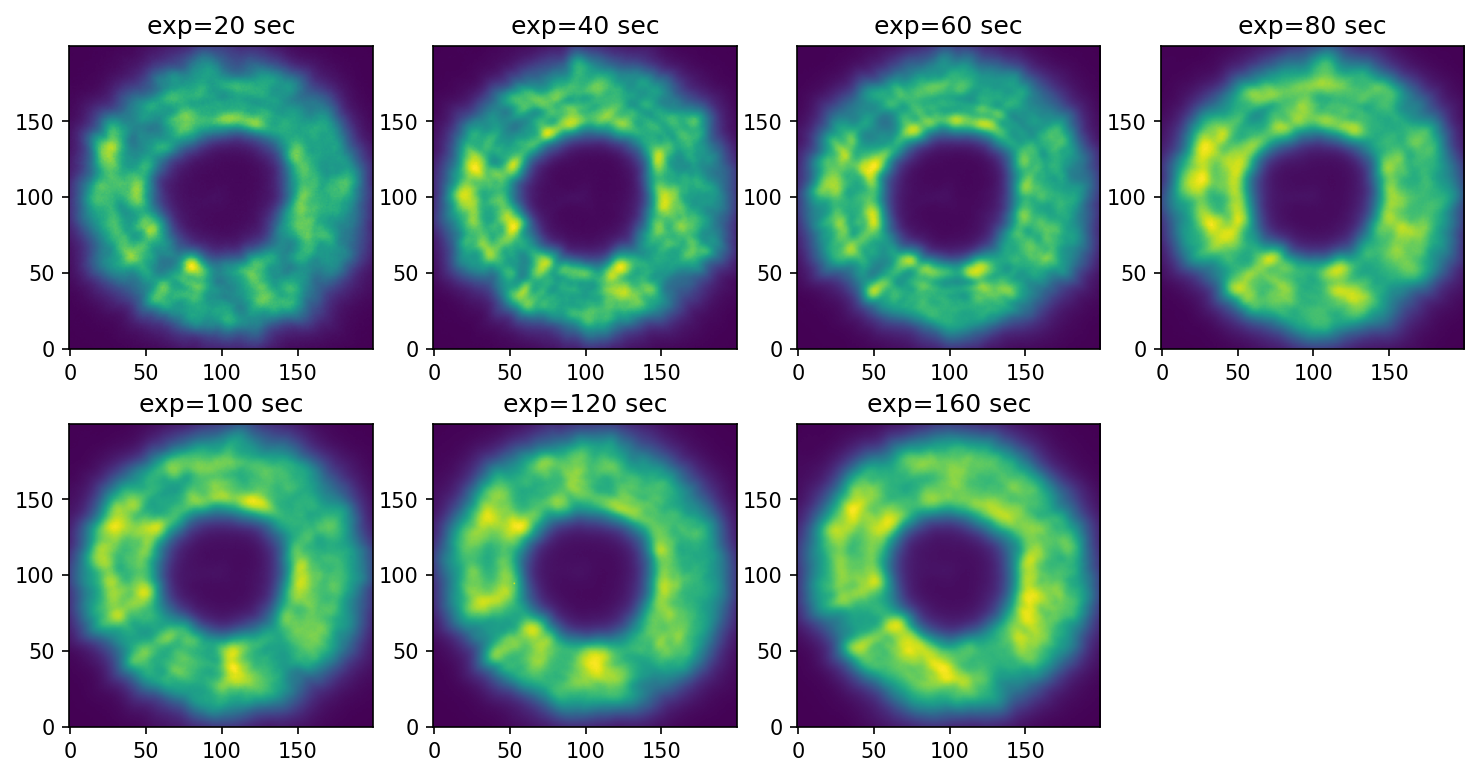

In [6]:
fig,axs = plt.subplots(2, 4, figsize=(12,6), dpi=150)
ax = np.ravel(axs)
for i in range(len(stamps)):
    ax[i].imshow(stamps[i][0].stamp_im.image.array, origin='lower')
    ax[i].set_title(f'exp={int(times[i])} sec')
ax[-1].axis('off')

As the exposure time increases, the level of detail decreases.

Show the retrieved Zernikes, with shading corresponding to exposure time. With longer exposure times, the power in individual Zernikes decreases overall:

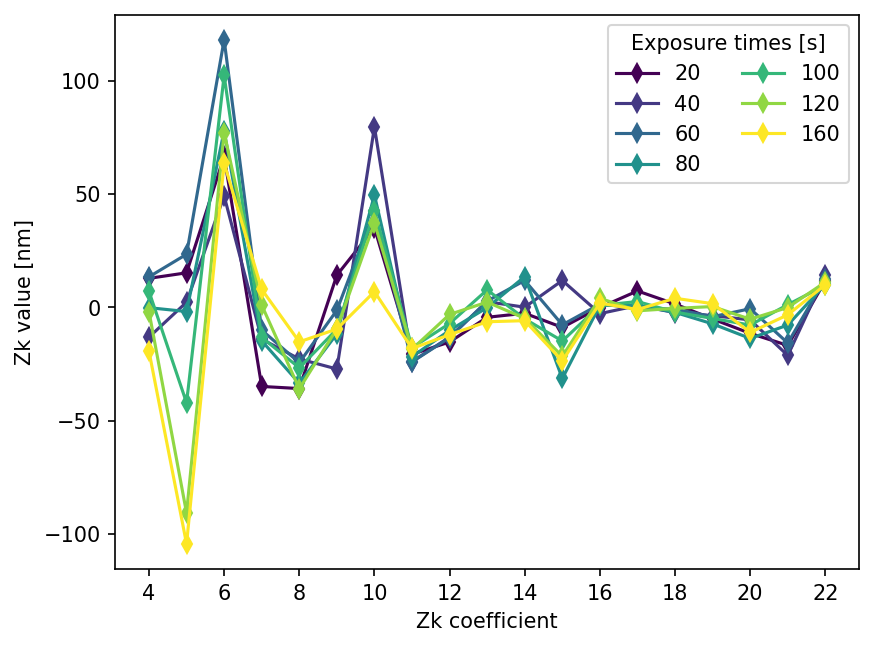

In [7]:
nlines = len(zernikes)
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.viridis

fig,ax = plt.subplots(1,1, dpi=150)
for i in range(len(zernikes)):
    color = cmap(color_idx[i])
    ax.plot(np.arange(4,23), 1000*zernikes[i], '-d', label=f'{int(times[i])}',
            color=color)
ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Zk coefficient')
ax.set_ylabel('Zk value [nm]')
ax.legend(title='Exposure times [s]', bbox_to_anchor=[1, 1.0], ncol=2)

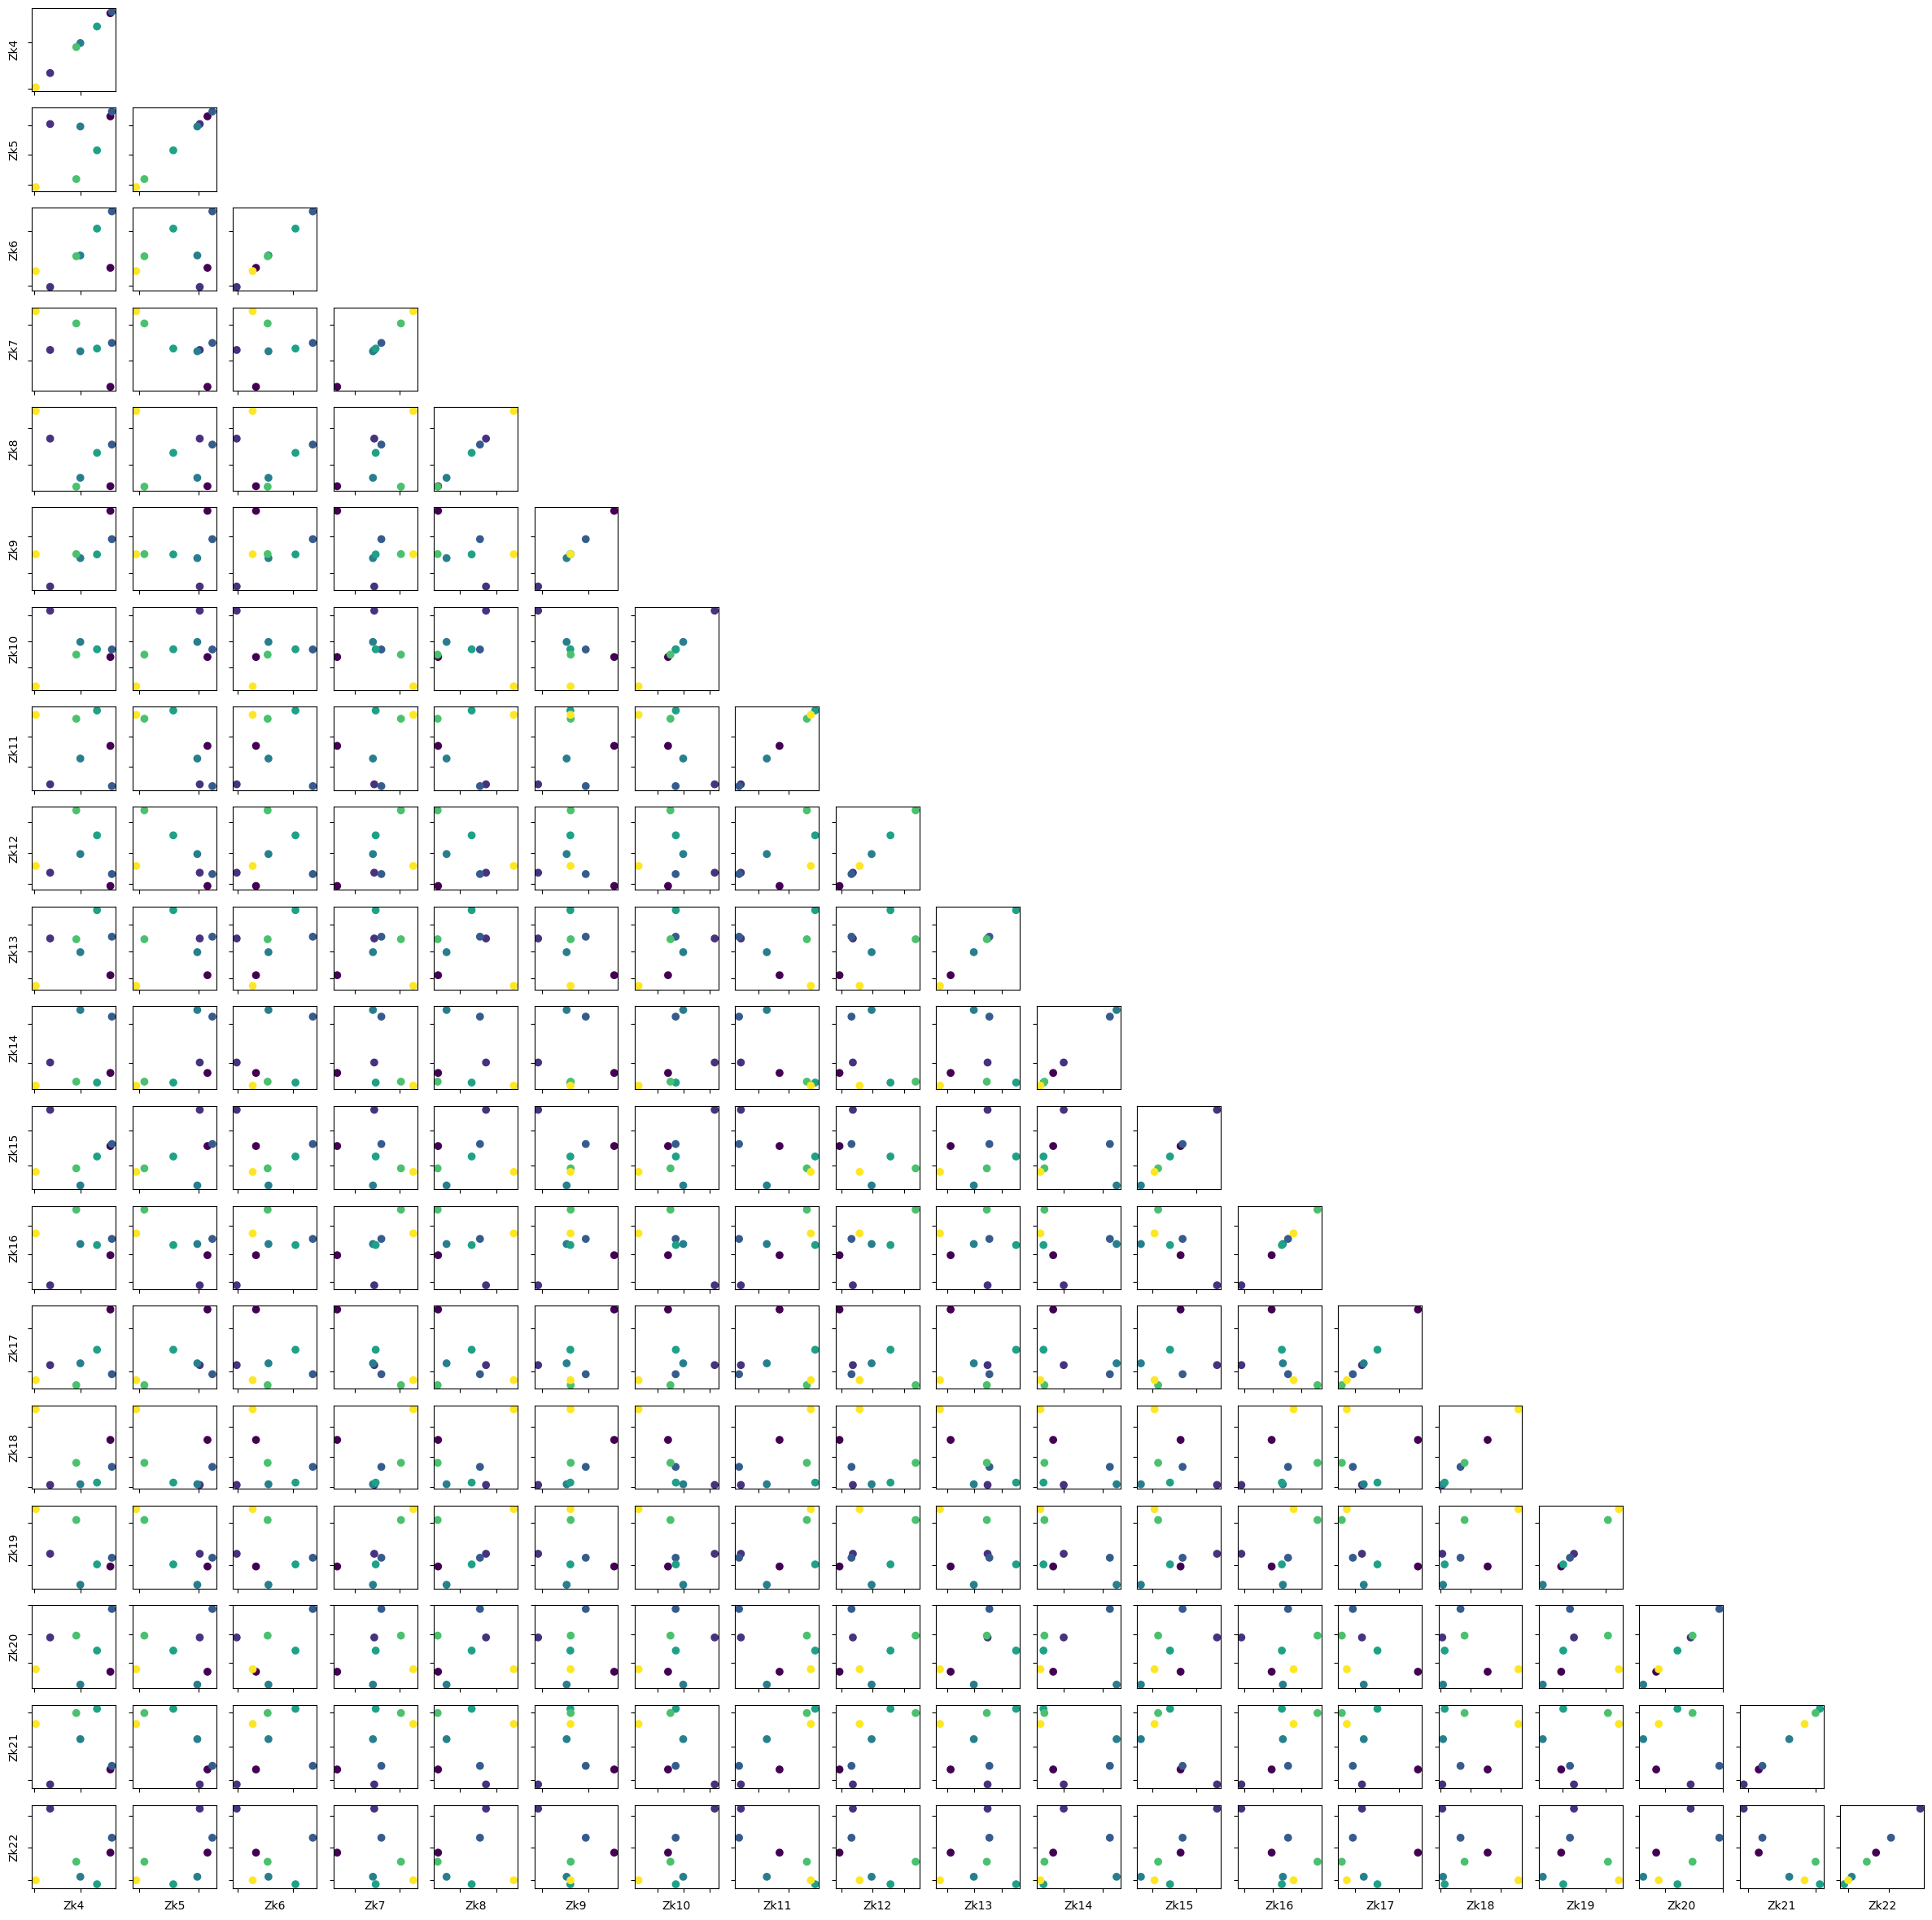

In [8]:
nrows = 19
ncols = nrows
fig,ax  = plt.subplots(ncols, nrows, figsize=(30,30))

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        if i>=j: 
            #print(f'row{i} col{j}, x=Zk{j+4} vs y=Zk{i+4}')
            ax[i,j].scatter(zernikes[:,j], zernikes[:,i],c=times)
            #ax[i,j].set_title(f'Zk{j+4} vs {i+4}')
        else:
            ax[i,j].axis('off')
            
row=18
for j in range(ncols):
    ax[row,j].set_xlabel(f'Zk{j+4}')
    
col = 0
for i in range(nrows):
    ax[i, col].set_ylabel(f'Zk{i+4}')
plt.savefig('auxTel_20230310_expTime_corner_plot.png', bbox_inches='tight')

This doesn't show any cross-correlations, but there is not enough data here to properly explore that.


Plot strength of each element of the polynomial expansion as  a function of time. For example,  160 sec exposure has much weaker Z10 than 20 sec:

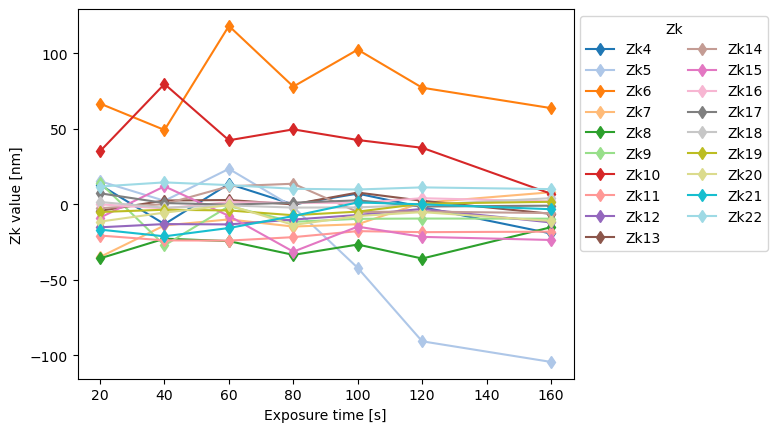

In [9]:
nlines = 19
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.tab20

fig,ax = plt.subplots(1,1)

for j in range(19):
    color = cmap(color_idx[j])
    ax.plot(times,   1000*zernikes[:,j], '-d', label=f'Zk{j+4}',
            color=color)
ax.set_xlabel('Exposure time [s]')
ax.set_ylabel('Zk value [nm]')
ax.legend(title='Zk', bbox_to_anchor=[1, 1.0], ncol=2)

Some Zernike coefficients react more strongly to increased exposure time, eg. Z5 (oblique astigmatism), Z6 (vertical astigmatism), Z10 (oblique trefoil). 

I convert Zernike coefficients to the PSF FWHM contribution using the `ts_phosim` [convertZernikesToPsfWidth](https://github.com/lsst-ts/ts_phosim/blob/develop/python/lsst/ts/phosim/utils/ConvertZernikesToPsfWidth.py) function:

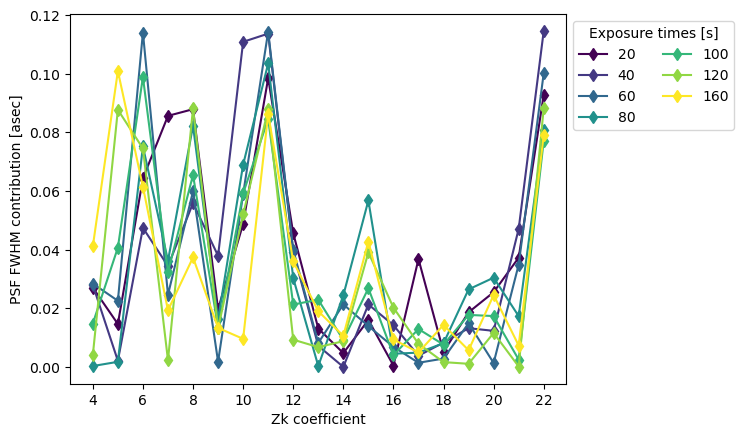

In [10]:
# this converts the Zernikes to nanometers 
# to FWHM contribution, multipltying by the RMS coefficient calculated  above 
nlines = len(zernikes)
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.viridis

fig,ax = plt.subplots(1,1)
psf_fwhm = []
strehls = []
for i in range(len(zernikes)):
    color = cmap(color_idx[i])
    
    zk_fwhm = convertZernikesToPsfWidth(zernikes[i] , R_inner=0.61, R_outer=1.2)
    # From the docstring for convertZernikesToPsfWidth:
    # For example, image we have a true set of zernikes, [Z4, Z5, Z6], such that
    # ConvertZernikesToPsfWidth([Z4, Z5, Z6]) = [0.1, -0.2, 0.3] arcsecs.
    # These Zernike perturbations increase the PSF FWHM by
    # sqrt[(0.1)^2 + (-0.2)^2 + (0.3)^2] ~ 0.37 arcsecs.

    psf_fwhm_contrib = np.sqrt(np.sum(np.square(zk_fwhm)))
    psf_fwhm.append(psf_fwhm_contrib)
    
    zkNm = 1000*zernikes[i] # convert to nm 
    waves = zkNm / 750. # convert to waves 

    strehl = np.square(1-0.5*np.sum(np.square(waves)))
    strehls.append(strehl)

    ax.plot(np.arange(4,23), np.abs(zk_fwhm), '-d', label=f'{int(times[i])}',color=color)  
    
ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Zk coefficient')
ax.set_ylabel('PSF FWHM contribution [asec]')
ax.legend(title='Exposure times [s]', bbox_to_anchor=[1, 1.0], ncol=2)

We also calculate the Strehl ratio - the "ratio of the intensity at the Gaussian image point (the origin of the reference sphere is the point of maximum intensity in the observation plane) in the presence of aberration, divided by the intensity that would be obtained if no aberration were present."  (["Basic Wavefront Aberration Theory for Optical Metrology" Wyant, Creath 1992](http://wyant.optics.arizona.edu/zernikes/Zernikes.pdf). It was also calculated for 2021-06-08 auxTel data in [this notebook](https://github.com/suberlak/AOS/blob/main/AOS_AuxTel_test_data_210608_434-471.ipynb). `ts_wep` calculates only Z4-22. We don't include Z1, which is related to the definition of phase for the wavefronts (arbitrary). Then "Z2 and Z3 are both tilts, that displace the PSF but don’t broaden it."  Thus we only include Z4 onwards:


Text(0.5, 0, 'Exposure time [s]')

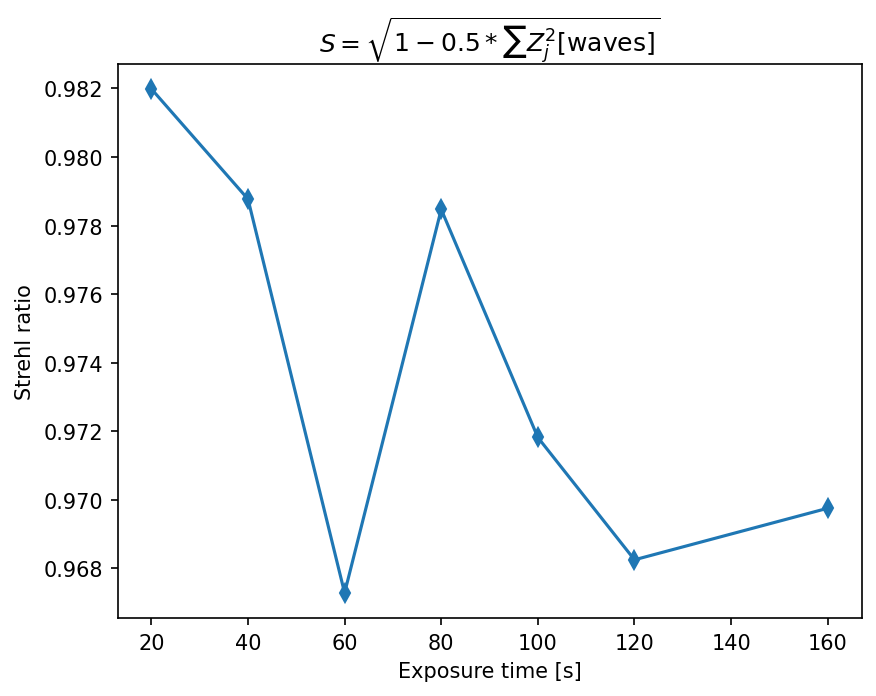

In [11]:
fig,ax = plt.subplots(1,1,dpi=150)
ax.plot(times, strehls, '-d')
ax.set_title('$S = \sqrt{1-0.5*\sum{Z_{j}^{2}[\mathrm{waves}]} }$')
ax.set_ylabel('Strehl ratio')
ax.set_xlabel('Exposure time [s]')

Text(0.5, 0, 'Exposure time [s]')

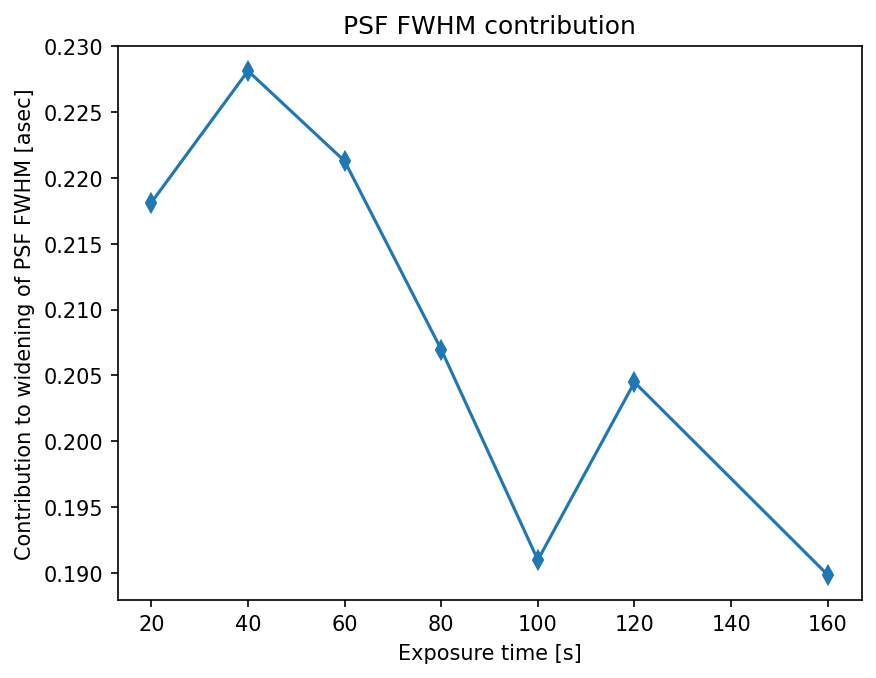

In [12]:
fig,ax = plt.subplots(1,1,dpi=150)
ax.plot(times, psf_fwhm, '-d')
ax.set_title('PSF FWHM contribution')
ax.set_ylabel('Contribution to widening of PSF FWHM [asec]')
ax.set_xlabel('Exposure time [s]')